Run the 7 cells below to load the CNN model and make predictions. You don't need to understand this part of the code. If you installed all the necessary imports, the rest should run without a problem. 

In [1]:
# Necessary imports
import keras
from keras.callbacks import Callback
from keras.models import Model,load_model, Sequential
from keras.layers import Input, LSTM, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Concatenate, ZeroPadding2D, UpSampling2D, UpSampling1D
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn

import numpy as np
from numpy import concatenate as concatenatenp
import math
import sys
import argparse
import matplotlib as mpl
#mpl.use('Agg') # disables showing plots
import matplotlib.backends.backend_pdf as backpdf
from  matplotlib import pyplot as plt
import pylab
import glob

import uproot

#from IPython.display import Image
#from IPython.display import display

2023-06-28 00:07:09.227147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [2]:
# Variable init
jetNum=0# number of jets in the input. will be filled with local input information
jetNum_validation = 0# number of jets in the input. will be filled with local input information
jetDim=30 #dimension of window on the pixed detector layer (cannot be changed without chaning the training sample)
overlapNum =3 #numer of overlap considered (cannot be changed without chaning the training sample)
layNum = 4 ## 4 for barrel, for endcap use layNum = 7 #4 barrel+3 endcap. the numeration is 1-4 for barrel, 5-7 for endcap (cannot be changed without chaning the training sample).
parNum=5 #number of track parameters (cannot be changed without chaning the training sample)
_Epsilon = 1e-7 #value needed for the loss functione valuation
inputModuleName= "DeepCoreNtuplizerTest" 
inputTreeName= "DeepCoreNtuplizerTree" 
batch_size = 64 # Batch size for training.
prob_thr =0.32 # threshold to identfy good prediciton (see DeepCore documentation to details)






In [3]:
# Class and function definition
class validationCall(Callback) : 
    def on_epoch_end(self,epoch, logs={}) :
        [call_par, call_prob] = self.model.predict([input_,input_jeta,input_jpt])
        call_prob = call_prob[:,:,:,:,:-1]

        for par in range(parNum) :
            bins = []# np.zeros(shape=(int(jetNum*valSplit)))
            nbin =0
            for j in range (int(jetNum*valSplit)) :
                j_eff = j+int(jetNum*(1-valSplit))
                for x in range(jetDim) :
                    for y in range(jetDim) :
                        for trk in range(overlapNum) :
                             if target_prob[j_eff][x][y][trk][0] == 1 :
                                if(par!=4) :
                                    bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])*0.01)
                                else :
                                     bins.append((call_par[j_eff][x][y][trk][par] - target_[j_eff][x][y][trk][par])/target_[j_eff][x][y][trk][par])  #relative
                                nbin = nbin+1

            plt.figure()
            pylab.hist(bins,100, facecolor='green', alpha=0.75)
            pylab.title('parNum error distribution_ep{EPOCH}_par{PAR}'.format(PAR=par,EPOCH=epoch))
            pylab.ylabel('entries')
            pylab.xlabel('parNum error')
            plt.grid(True)
            # pylab.savefig("parameter_error_{EPOCH}_{PAR}.pdf".format(PAR=par,EPOCH=epoch))
            pdf_par.savefig()

        N_eff_4 = 0
        N_eff_8 = 0
        N_fake_4 =0
        N_fake_8 = 0
        genTrackNum=3
        N_tot_eff = jetNum*valSplit*genTrackNum
        N_tot_fake = 0
        layDist=3
        for j in range (int(jetNum*valSplit)) :
            j_eff = j+int(jetNum*(1-valSplit))
            for x in range(jetDim) :
                for y in range(jetDim) :
                    for trk in range(overlapNum) :
                        if target_prob[j_eff][x][y][trk][0]==1 :
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2<=4  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_4 = N_eff_4 +1
                            if chi2<=8  and call_prob[j_eff][x][y][trk]>prob_thr:
                                N_eff_8 = N_eff_8 +1
                        if call_prob[j_eff][x][y][trk] > prob_thr :
                            N_tot_fake = N_tot_fake +1
                            chi2x = (call_par[j_eff][x][y][trk][0] - target_[j_eff][x][y][trk][0])**2
                            chi2y = (call_par[j_eff][x][y][trk][1] - target_[j_eff][x][y][trk][1])**2
                            chi2xt = (call_par[j_eff][x][y][trk][2] - target_[j_eff][x][y][trk][2])**2 / math.atan(2/float(layDist*3))
                            chi2yt = (call_par[j_eff][x][y][trk][3] - target_[j_eff][x][y][trk][3])**2 / math.atan(2/float(layDist*3))
                            chi2 = chi2x+chi2y+chi2xt+chi2yt
                            if chi2>=4  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_4 = N_fake_4 +1
                            if chi2>=8  and target_prob[j_eff][x][y][trk][0]==1:
                                N_fake_8 = N_fake_8 +1

        efficiency_4[epoch] = N_eff_4/N_tot_eff
        if N_tot_fake == 0 :
            fake_rate_4[epoch] = 1
        else :
           fake_rate_4[epoch] = N_fake_4/N_tot_fake

        efficiency_8[epoch] = N_eff_8/N_tot_eff
        if N_tot_fake == 0  :
            fake_rate_8[epoch] = 1
        else :
           fake_rate_8[epoch] = N_fake_8/N_tot_fake

#callback to have additional trained model every 10 epochs
class wHistory(keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
       if epoch % 10 == 0 :
               self.model.save("trained"+str(epoch+0)+".h5")
wH = wHistory()

#callback to have the weight saved every batch
class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'weights%08d.h5' % self.batch
            self.model.save_weights(name)
        self.batch += 1

#used in EXTRA_VALIDATION to have additional log info
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()


#used in the losses
def _to_tensor(x, dtype):
    return ops.convert_to_tensor(x, dtype=dtype)

#used in the losses
def epsilon():
    return _Epsilon

#loss function for probability, used in the first part of the training
def loss_ROI_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*wei
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum(wei,axis=None)+0.00001) #0.00001 needed to avoid numeric issue
    #return tf.reduce_sum(retval, axis=None)

#loss function for probability, used in the last part of the training (difference: non-zero weight to pixel far from crossing point)
def loss_ROIsoft_crossentropy(target, output):
    epsilon_ = _to_tensor(keras.backend.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    wei = target[:,:,:,:,-1:]
    target = target[:,:,:,:,:-1]
    output = output[:,:,:,:,:-1]
    output = math_ops.log(output / (1 - output))
    retval = nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=10)#900=works #2900=200x200, 125=30x30
    retval = retval*(wei+0.01) # here the difference
    return tf.reduce_sum(retval, axis=None)/(tf.reduce_sum((wei+0.01),axis=None))

#loss for track parameter
def loss_mse_select_clipped(y_true, y_pred) :
    wei = y_true[:,:,:,:,-1:]
    pred = y_pred[:,:,:,:,:-1]
    true =  y_true[:,:,:,:,:-1]
    print(wei)
    print(pred)
    out =K.square(tf.clip_by_value(pred-true,-5,5))*wei
    return tf.reduce_sum(out, axis=None)/(tf.reduce_sum(wei,axis=None)*5+0.00001) #5=parNum

# Generator used to load all the input file in the LOCAL_INPUT=False workflow
## Changed uproot to uproot3 in order to use central sample

In [4]:
# Generator 2 Definition
def Generator2(filepath,batch_size=0,count=False):

    if count:
        branches = ["jet_eta"]
        batch_size = 9000
    else:
        branches = ["cluster_measured","jet_eta","jet_pt","trackPar","trackProb"]

    while 1:
        for cycle in range(1,9):
           # print(cycle)
            for chunk in uproot.iterate("{}:{}/{};{}".format(filepath,inputModuleName,inputTreeName,str(cycle)),branches,step_size=batch_size,library="np"):
                if count:
                    yield chunk['jet_eta'].shape[0]
                else:
                    nev = len(chunk["trackProb"])

                    target_prob = np.reshape(chunk["trackProb"], (nev,jetDim,jetDim,overlapNum,1))

                    target_prob = concatenatenp([target_prob,chunk["trackPar"][:,:,:,:,-1:]],axis=4)
                    ## debug
                    ##pdb.set_trace()
                    
                    
                    yield [chunk['cluster_measured'][:,:,:,0:layNum],chunk["jet_eta"],chunk["jet_pt"]],[chunk["trackPar"],target_prob]
                    
        if count:
            break

In [5]:
# Loading Testing samples

inputs = []
tot_events = 0

#testing_path ="testing_samples/Fixed_samples*"
#testing_path ="testing_samples/New_sample*"
# old training files
#testing_path ="testing_samples/old_TestingSamples/DeepCoreTrainingSample*"
# new training files
testing_path ="TestingSamples/DeepCoreTraining*"

print("number of  testing files=", len(glob.glob(testing_path)))

for batch in Generator2(testing_path,count=True):
        #pdb.set_trace()
        tot_events += batch
        
jetNum = tot_events
print("total number of events =", jetNum)


number of  testing files= 2
total number of events = 61466


In [6]:
# DeepCore 2.0/2.1 Architecture

from keras.layers import AlphaDropout

NNinputs_jeta = Input(shape=(1,))
NNinputs_jpt = Input(shape=(1,))
NNinputsJet = concatenate([NNinputs_jeta,NNinputs_jpt])
jetReshaped = Reshape((1,1,2))(NNinputsJet)
jetUps = UpSampling2D(size=(jetDim,jetDim), data_format="channels_last")(jetReshaped)
print("jetUps=", jetUps.shape)
NNinputs = Input(shape=(jetDim,jetDim,layNum))
print("NNinputs=", NNinputs.shape)
ComplInput = concatenate([NNinputs,jetUps],axis=3)
print("ComplInput=", ComplInput.shape)

conv30_9 = Conv2D(50,7, data_format="channels_last", input_shape=(jetDim,jetDim,layNum+2), activation='relu',padding="same")(ComplInput)
conv30_7 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_9)
conv30_5 = Conv2D(40,5, data_format="channels_last", activation='relu',padding="same")(conv30_7)#
conv20_5 = Conv2D(30,5, data_format="channels_last", activation='relu',padding="same")(conv30_5)
conv15_5 = Conv2D(30,3, data_format="channels_last", activation='relu',padding="same")(conv20_5)

conv15_3_1 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_5)
conv15_3_2 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_1)
conv15_3_3 = Conv2D(30,3, data_format="channels_last",activation='relu', padding="same")(conv15_3_2) #(12,3)
conv15_3 = Conv2D(18,3, data_format="channels_last",padding="same")(conv15_3_3) #(12,3)
reshaped = Reshape((jetDim,jetDim,overlapNum,parNum+1))(conv15_3)

conv12_3_1 = Conv2D(30,3, data_format="channels_last", activation='relu', padding="same")(conv15_5)  #new
conv1_3_2 = Conv2D(25,3, data_format="channels_last", activation='relu', padding="same")(conv12_3_1) #drop7lb   #new
conv1_3_3 = Conv2D(20,3, data_format="channels_last", activation='relu',padding="same")(conv1_3_2) #new
conv1_3_1 = Conv2D(6,3, data_format="channels_last", activation='sigmoid', padding="same")(conv1_3_3)
reshaped_prob = Reshape((jetDim,jetDim,overlapNum,2))(conv1_3_1)

model = Model([NNinputs,NNinputs_jeta,NNinputs_jpt],[reshaped,reshaped_prob])
anubi = tf.keras.optimizers.Adam(learning_rate=0.0000001)#after epochs 252 (with septs/20 and batch_size 64)

#model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROI_crossentropy], loss_weights=[1,1]) #FOR EARLY TRAINING
model.compile(optimizer=anubi, loss=[loss_mse_select_clipped,loss_ROIsoft_crossentropy], loss_weights=[1,1]) #FOR LATE TRAINING

model.summary()


jetUps= (None, 30, 30, 2)
NNinputs= (None, 30, 30, 4)
ComplInput= (None, 30, 30, 6)


2023-06-28 00:07:19.465564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_fo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 1, 2)      0           ['concatenate[0][0]']        

In [7]:
# Loading DeepCore model and evaluation of test files

inputs = []
chunk = next(Generator2(testing_path,batch))
inputs.append(chunk[0])

## Importing model
model.load_weights('DeepCore_213.h5')
#model.summary()

## Making all the predictions
[validation_par,validation_prob] = model.predict(inputs)
validation_par = np.float64(validation_par)

The initial setup is now done. You may stop running cells blindly :)

The format of the prediction arrays are as follow: 

1) validation_prob[merged_cluster, x,  y, track, [probability, fake probability]]

2) validation_par[merged_cluster, x,  y, track, [dx, dy, deta, dphi, 1/pt, zero_flag]] 

- Your inputs are merged cluster --> N

- Your image size is x = 30 by y = 30.

- For every pixel (30*30 = 900) in every merged cluster there are 3 predicted tracks so track = 3.

- For every predicted track in every pixel of every merged cluster, you have a prediction score in validation_prob (how likely that a particle crossed this pixel) and predicted parameters in validation_par (dx, dy, deta, dphi, 1/pt). Please ignore "fake probability" and "zero_flag".

If this is a bit confusing, I've included a few useful print outs below to convince yourself of this format:

In [8]:
# Debugging printouts
print(validation_prob.shape) # (merged cluster, x, y, track, prediction)
print(validation_par.shape) # 5 predicted track param and predicted zero flag
#print(validation_prob)
#print(validation_prob[0]) # prints out everything for input 0 (1st merged hit)
#print(validation_prob[0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = 0
#print(validation_prob[0,0,0,0]) # prints out everything for input 0 (1st merged hit) and x = y = track = 0
#print(validation_prob[0,0,0,0,0]) # prints prediction (ignore 2nd prediction since it's softmax) for input 0 and x = y = track = 0



(3915, 30, 30, 3, 2)
(3915, 30, 30, 3, 6)


The format of the target/truth information has similar formatting to the prediction, but it included in the Training sample input array, which also contains the CNN input information.

For DeepCore to make a prediction, it requires this input information for every merged cluster: the charge deposit on every pixel of every layer (30*30*4), jet pt and jet eta.

The target information is included in chunk[1], while the input information is included in chunk[0]. 

- Target Track Parameters: chunk[1][0][merged_cluster][x][y][track][dx,dy,deta,dphi,1/pt,prob_flag] (ignore "prob_flag").

- Target Track Score: chunk[1][1][merged_cluster][x][y][track][target_score] (1 if a particle crossed a pixel, 0 otherwise).

- Merged cluster charge deposit: chunk[0][0][merged_cluster][x][y][layer] (4 layers)

- Merged cluster jet eta: chunk[0][1][merged_cluster]

- Merged cluster jet pt: chunk[0][2][merged_cluster]

 I've included a few useful print outs below:

In [9]:
# Debugging printouts
#print(chunk[1][0][0][0][0][0][0]) # prints target parameter dx for 1st merged cluster and x = y = track = 0
#print(chunk[1][1][0][0][0][0][0]) # prints target score (0 or 1) for 1st merged cluster and x = y = track = 0
#print(chunk[0][0][0][0][0][1]) # prints charge deposit in a pixel on layer 2 for 1st Merged cluster and x = y = 0 
#print(chunk[0][1][1]) # print jet eta of 2nd merged cluster

A couple more print outs for fun

In [10]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 10
print("merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt")
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(3) : # loop over tracks
                if chunk[1][1][i][j][k][l][0] ==1 and validation_prob[i,j,k,l,0]>0.8:
                    print("    ",i,"        ", j, k, "  ", round(validation_prob[i,j,k,l,0],4),"  ", round(chunk[1][0][i][j][k][l][0],4),"  ", round(chunk[1][0][i][j][k][l][1], 4),"  ", round(chunk[1][0][i][j][k][l][2], 4) ,"  ", round(chunk[1][0][i][j][k][l][3],4) ,"  ", round(chunk[1][0][i][j][k][l][4],4) )
                    

merged cluster, x, y,   pred score, true dx,  true dy, true deta, true dphi, true 1/pt
     2          4 20    0.9192    -0.1005    -0.6577    -0.9821    1.7226    0.0779
     2          4 22    0.9536    -0.3604    -0.1166    -1.4509    2.044    0.2482
     2          7 22    0.9661    -0.0007    0.5963    -1.5641    1.7378    0.0713
     2          9 22    0.9659    0.2084    -0.3471    -1.4351    0.8282    0.0215
     2          12 23    0.9367    0.3498    0.6217    -1.7701    0.4258    0.0026
     2          12 24    0.972    0.4553    0.0793    -1.8865    0.4243    0.0857
     2          12 24    0.9206    0.4554    0.0792    -1.8826    0.4199    0.0036
     2          13 15    0.895    -0.3377    0.1479    -0.0747    0.455    0.0179
     2          15 14    0.8466    -0.1566    -0.2903    0.1922    -0.1344    0.052
     3          11 13    0.8914    -0.1005    -0.6577    0.4205    0.6239    0.0779
     3          11 15    0.8911    -0.3604    -0.1166    -0.0482    0.9453    0.24

In [11]:
# Debugging printouts: Printing prediction, target probility and track number if target = 1
N = 2
for i in range(N): # loop over input
    for j in range(30): # loop over x
        for k in range(30): # loop over y
            for l in range(1) : # loop over tracks
                # TCP
                pixel_true_prob = chunk[1][1][i][j][k][l][0]
                pixel_pred_prob = validation_prob[i,j,k,l,0]
                # True TP
                pixel_true_dx = chunk[1][0][i][j][k][l][0]
                pixel_true_dy = chunk[1][0][i][j][k][l][1]
                pixel_true_deta = chunk[1][0][i][j][k][l][2]
                pixel_true_dphi = chunk[1][0][i][j][k][l][3]
                pixel_true_invpt = chunk[1][0][i][j][k][l][4]
                # Predicted TP
                pixel_pred_dx = validation_par[i,j,k,l,0]
                pixel_pred_dy = validation_par[i,j,k,l,1]
                pixel_pred_deta = validation_par[i,j,k,l,2]
                pixel_pred_dphi = validation_par[i,j,k,l,3]
                pixel_pred_invpt = validation_par[i,j,k,l,4]
                # merged cluster inputs (layer 2)
                pixel_lay2_adc = chunk[0][0][i][j][k][1]
                merged_cluster_eta = chunk[0][1][i]
                merged_cluster_pt = chunk[0][2][i]
                if pixel_true_prob ==1: 
                    print("Pixel (",j,",",k,"): True     vs   Predicted")
                    print("     Probability:",  round(pixel_true_prob,3), "     vs ", pixel_pred_prob )
                    print("              dx: ",  round(pixel_true_dx,3), " vs ",  round(pixel_pred_dx, 3) )
                    print("              dy: ",  round(pixel_true_dy,3), " vs ",  round(pixel_pred_dy, 3) )
                    print("            deta: ",  round(pixel_true_deta,3), " vs ",  round(pixel_pred_deta, 3) )
                    print("            dphi: ",  round(pixel_true_dphi,3), " vs ",  round(pixel_pred_dphi, 3) )
                    print("            1/pt: ",  round(pixel_true_invpt,3), " vs ",  round(pixel_pred_invpt, 3) )
                    print(merged_cluster_pt)

Pixel ( 12 , 8 ): True     vs   Predicted
     Probability: 1.0      vs  0.6260847
              dx:  0.476  vs  0.268
              dy:  0.411  vs  -0.189
            deta:  0.701  vs  0.988
            dphi:  0.302  vs  0.418
            1/pt:  0.033  vs  0.037
1689.2861328125
Pixel ( 12 , 16 ): True     vs   Predicted
     Probability: 1.0      vs  0.3413669
              dx:  0.411  vs  0.296
              dy:  0.708  vs  1.478
            deta:  -0.291  vs  -0.349
            dphi:  0.421  vs  0.376
            1/pt:  0.005  vs  0.052
1689.2861328125
Pixel ( 15 , 18 ): True     vs   Predicted
     Probability: 1.0      vs  0.64308023
              dx:  0.014  vs  0.052
              dy:  0.356  vs  -0.219
            deta:  -0.38  vs  -0.382
            dphi:  0.097  vs  -0.033
            1/pt:  0.01  vs  0.007
1689.2861328125
Pixel ( 16 , 16 ): True     vs   Predicted
     Probability: 1.0      vs  0.78449345
              dx:  0.27  vs  -0.397
              dy:  0.463  vs  0.77

Now that you understand the format of the training samples, we can start plotting. We want to plot the TCPs (Track Crossing Points) that pass a threshold (Let's say that thershold is 0.8) and that are associated to a true TCP (target_score = 1). Any plot you make should have this condition.

1) Plot jet eta and jet pt for all merged clusters. Hint: this does not require TCPs.

2) Plot "predicted dx" for every TCP (every pixel that satisifies the condition above). Hint: my printouts above are very helpful.

3) Plot "target pt" for every TCP. Hint: I said pt, not 1/pt.

4) Plot "residual deta" for every TCP. Hint: Residual means (prediction - target).

5) plot "predicted dphi vs target dphi" for every TCP. Hint: look up plt.hist2d function and colorbar.

6) Plot "predicted dy vs target dy" only if the sum of charge on layer 2 is nonzero. Hint: look up how how to sum arrays along a particular axis.

This assignement is supposed to take you a week and requires you learn a lot of python on your own. This is will be essential for the next step, so don''t worry if you feel very confused at first, it's supposed to take time. If you cannot figure this out in a week, I will send you the solution.


In [27]:
# DeepCore 2.1.3 Param plots definition and set up

# Residual Plots
def residual_plots(par, bins):
    if(par== 0) :
        pylab.hist(bins,80,facecolor='darkorange',alpha=0.75,range=(-150,150))
        pylab.title('Residual Distribution - $\Delta x$',fontsize=22)
        # Plotting the mean and sd if needed
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(80, 50000, "Mean =%.2f $\mu$m"%(mean), size=14) 
        #plt.text(80, 60000, "$\sigma_{\Delta x}$ = %.1f $\mu$m"%(sigma), size=14)
        # the tricky part is adjusting the height (50000 for the mean) every time you change statistics
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,120, facecolor='darkorange',alpha=0.75,range=(-200,200))
        pylab.title('Residual Distribution - $\Delta y$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(100, 50000, "Mean =%.1f $\mu$m"%(mean), size=14)
        #plt.text(100, 60000, "$\sigma_{\Delta y}$ = %.1f $\mu$m"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target [$\mu$m]',fontsize=22)
        plt.grid(True)
    if(par== 2):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \eta$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 130000, "Mean = 0", size=14)
        #plt.text(0.01, 150000, "$\sigma_{\Delta \eta}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if(par == 3):
        pylab.hist(bins,100, facecolor='darkorange',alpha=0.75,range=(-0.02,0.02))
        pylab.title('Residual Distribution - $\Delta \phi$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(0.01, 80000, "Mean = 0", size=14)
        #plt.text(0.01, 90000, "$\sigma_{\Delta \phi}$ = %.3f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('Prediction-Target',fontsize=22)
        plt.grid(True)
    if (par == 4) :
        pylab.hist(bins,150, facecolor='darkorange', alpha=0.75,range=(-3,12))#range=(-0.2,0.2))#range=(-2,5)) #relative
        pylab.title('Residual Distribution - p_T$',fontsize=22)
        #mean = np.array(bins).mean()
        #sigma = np.array(bins).std()
        #plt.text(4, 28000, "Mean =%.1f"%(mean), size=14)
        #plt.text(4, 25000, "$\sigma_{\Delta(1/p_T)rel}$ = %.1f"%(sigma), size=14)
        pylab.ylabel('TCP',fontsize=18)
        pylab.xlabel('(Prediction-Target)/Target',fontsize=18) #only 1/pt
        plt.grid(True)
   # plt.figure()      

# Target Plots
def target_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-100,100))
        pylab.title('Target Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 1) :
        pylab.hist(bins,100, facecolor='royalblue', alpha=0.75,range=(-150,150))
        pylab.title('Target Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Target [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 3) :
        pylab.hist(bins,90, facecolor='royalblue', alpha=0.75,range=(-0.04,0.04))
        pylab.title('Target Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Target',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4):
        pylab.hist(bins,100, facecolor='royalblue',alpha=0.75,range=(0,200))
        pylab.title('Target Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Target [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(False)
   # plt.figure()

# Prediction Plots
def pred_plots(par, bins):
    if(par == 0):
        pylab.hist(bins,80, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta x$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==1) :
        pylab.hist(bins,120, facecolor='red', alpha=0.75,range=(-150,150))
        pylab.title('Prediction Distribution - $\Delta y$',fontsize=22)
        pylab.xlabel('Prediction [$\mu$m]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par == 2) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \eta$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if(par ==3 ) :
        pylab.hist(bins,70, facecolor='red', alpha=0.75,range=(-0.03,0.03))
        pylab.title('Prediction Distribution - $\Delta \phi$',fontsize=22)
        pylab.xlabel('Prediction',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    if (par ==4) :
        pylab.hist(bins,100, facecolor='red',alpha=0.75,range=(0,200))
        pylab.title('Prediction Distribution - $p_T$',fontsize=22)
        pylab.xlabel('Prediction [GeV]',fontsize=18)
        pylab.ylabel('TCP',fontsize=18)
        plt.grid(True)
    #plt.figure()
        
# Scatter Plots
def scatter_plots(par, bins_x, bins_y):
    if(par == 0) :
        nx = 100
        plt.hist2d(bins_x, bins_y,bins=nx,range= [[-nx,nx], [-nx, nx]], cmap=plt.cm.viridis)#, marker='+')
        # Plotting diagonal
        l_x = [-150, 150]
        plt.plot(l_x, l_x, color='black') 
        pylab.title('Prediction vs Target - $\Delta x$',fontsize=22)
        plt.ylabel('Predicted $\Delta x$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta x$ [$\mu$m]', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 1) :
        ny = 150
        plt.hist2d(bins_x,bins_y,bins=ny,range= [[-ny,ny], [-ny, ny]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_y = [-225,225]
        plt.plot(l_y, l_y, color='black') 
        pylab.title('Prediction vs Target - $\Delta y$',fontsize=22)
        plt.ylabel('Predicted $\Delta y$ [$\mu$m]', fontsize=18)
        plt.xlabel('Target $\Delta y$ [$\mu$m]', fontsize=18)
        # Plotting other lines
        #l_pt = [-75,75]
        #l_zero = [0,0]
        #l_1 = [10,10]
        #l_2 = [-10,-10]
        #plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_pt, l_1, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_2, color='black', linestyle='dashed')
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        plt.colorbar()
        plt.grid(False)
    if(par == 2) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_eta = [-0.04,0.04]
        plt.plot(l_eta, l_eta, color='black') 
        pylab.title('Prediction vs Target - $\Delta \eta$',fontsize=22)
        plt.ylabel('Predicted $\Delta \eta$ ', fontsize=18)
        plt.xlabel('Target $\Delta \eta$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 3) :
        plt.hist2d(bins_x,bins_y,bins=180,range = [[-0.03,0.03], [-0.03, 0.03]], cmap=plt.cm.viridis)
        # Plotting diagonal
        l_phi = [-0.04,0.04]
        plt.plot(l_phi, l_phi, color='black') 
        pylab.title('Prediction vs Target - $\Delta \phi$',fontsize=22)
        plt.ylabel('Predicted $\Delta \phi$', fontsize=18)
        plt.xlabel('Target $\Delta \phi$', fontsize=18)
        plt.colorbar()
        plt.grid(False)
    if(par == 4) :
        plt.hist2d(bins_x,bins_y,bins=100,range= [[0,200], [0, 200]])
        # Plotting diagonal
        l_pt = [0, 200]
        #l_zero = [0,0]
        plt.plot(l_pt, l_pt, color='black') 
        #plt.plot(l_zero, l_pt, color='black', linestyle='dashed') 
        #plt.plot(l_pt, l_zero, color='black', linestyle='dashed') 
        pylab.title('Prediction vs Target - $p_T$',fontsize=22)
        plt.ylabel('Predicted $p_T$ [GeV]', fontsize=18)
        plt.xlabel('Target $p_T$ [GeV]', fontsize=18)
        plt.colorbar()
        plt.grid(False)


    
parNum = 5 # TP
N = 3800 # Merged clusters
Nx = 30 # x dimension
Ny = 30 # y dimension
Nt = 3 # max Overlap

#DeepCore 2.1.3 Thresholds
prob_threshold = [0.7, 0.85, 1] 
prob_dth_l134 = [0.1, 0.05, 0]
prob_dth_l2 = [0.3, 0.15, 0]

jet_pt = []
jet_eta = []
pbins = [None] * parNum
pbins_pred = [None] * parNum
pbins_target = [None] * parNum
for par in range(parNum) :
    bins = []
    bins_pred = []
    bins_target = []
    for i in range(N): # loop over input
        dth_l134 = 1
        dth_l2 = 1
        A = np.array(chunk[0][0][i])
        S= np.sum(A, axis=(0,1))
        if (S[0]*S[2]*S[3]):
            dth_l134 = 0
        if (S[1]):
            dth_l2 = 0
        jet_pt.append(chunk[0][2][i])
        jet_eta.append(chunk[0][1][i])
        for j in range(Nx): # loop over x
            for k in range(Ny): # loop over y
                for l in range(Nt) : # loop over tracks
                    pixel_true_prob = chunk[1][1][i][j][k][l][0]
                    pixel_pred_prob = validation_prob[i,j,k,l,0]
                    if (pixel_pred_prob > (prob_threshold[l] + dth_l134*prob_dth_l134[l] + dth_l2*prob_dth_l2[l] )) and (pixel_true_prob == 1): 
                        #threshold DeepCore 2.1.3
                        if((par==0) or (par ==1)) : # dx or dy
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*100)
                            bins_pred.append(validation_par[i,j,k,l,par]*100)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*100)
                        elif((par==2) or (par ==3)) : # deta or dphi
                            bins.append((validation_par[i,j,k,l,par] - chunk[1][0][i][j][k][l][par])*0.01)
                            bins_pred.append(validation_par[i,j,k,l,par]*0.01)
                            bins_target.append(chunk[1][0][i][j][k][l][par]*0.01)
                        else : #pt
                            bins.append((1/validation_par[i,j,k,l,par] - 1/chunk[1][0][i][j][k][l][par])/ (1/chunk[1][0][i][j][k][l][par]))  #relative
                            bins_pred.append(1/validation_par[i,j,k,l,par])
                            bins_target.append(1/chunk[1][0][i][j][k][l][par])
    pbins[par] = bins
    pbins_pred[par] = bins_pred
    pbins_target[par] = bins_target
           


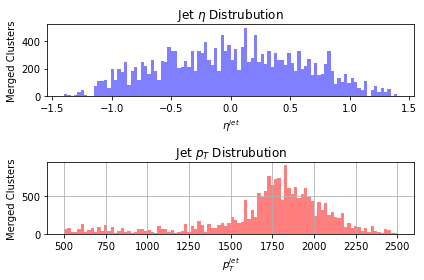

In [28]:
# jet pt and eta plotted together (I prefer separately)
bins_eta = 100
bins_pt = 100
fig, (j_eta, j_pt) = plt.subplots(2, 1)

j_eta.hist(jet_eta, bins=bins_eta, color='b',range = (-1.4,1.4), alpha=0.5)
j_eta.set_title('Jet $\eta$ Distrubution')
j_eta.set_xlabel('$\eta^{jet}$')
j_eta.set_ylabel('Merged Clusters')
j_pt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
j_pt.set_title('Jet $p_T$ Distrubution')
j_pt.set_xlabel('$p_T^{jet}$')
j_pt.set_ylabel('Merged Clusters')
plt.tight_layout()
#plt.savefig("Jet_eta_and_pt.png")
plt.grid(True)
plt.show()

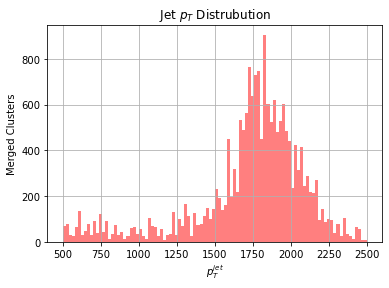

In [29]:
# jet pt distribution
bins_pt = 100
plt.hist(jet_pt, bins=bins_pt, color='r', range = (500, 2500), alpha=0.5)
plt.title('Jet $p_T$ Distrubution')
plt.xlabel('$p_T^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

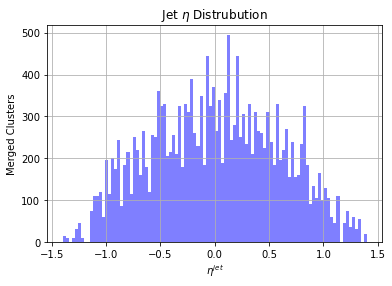

In [30]:
# jet eta distribution
bins_eta = 100
plt.hist(jet_eta, bins=bins_eta, color='b', range = (-1.4, 1.4), alpha=0.5)
plt.title('Jet $\eta$ Distrubution')
plt.xlabel('$\eta^{jet}$')
plt.ylabel('Merged Clusters')
plt.grid(True)
plt.show()

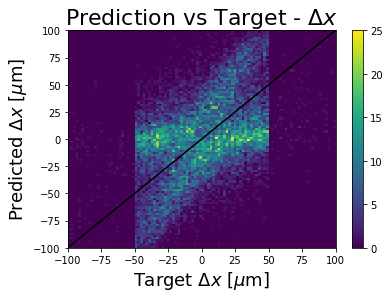

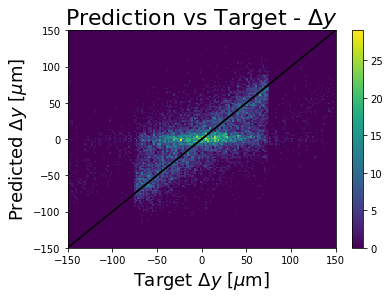

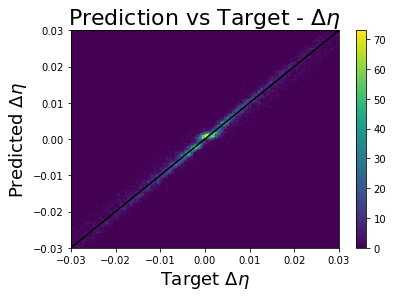

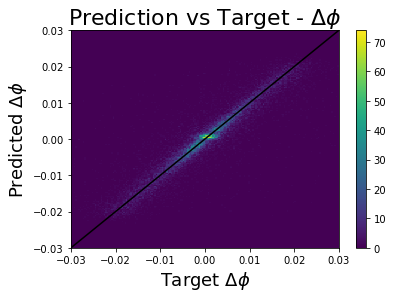

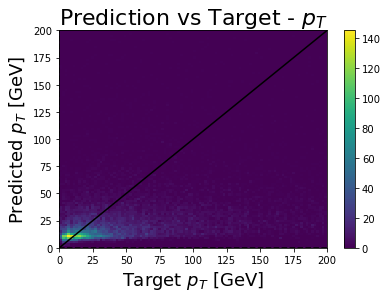

<Figure size 432x288 with 0 Axes>

In [34]:
# Param Plots
for n in range(0,5):
    scatter_plots(n, pbins_target[n], pbins_pred[n])
    #target_plots(n, pbins_target[n])
    #pred_plots(n, pbins_pred[n])
    #residual_plots(n, pbins[n])
    plt.figure()